In [106]:
# imports
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
import numpy as np
import cv2
import time


# Skeletonization of Binary Images


## Premises

In this notebook I implement, demonstrate and compare various algorithms to perform Skeletonization of 2D images. For each algoritm presented there is a brief explanation of its logic and mechanism. The algorithms presented are:

1.  Zhang's algorithms (1984)
2.  Lee's algorithms (1994)
3.  Morphological Thinning

My implementations are not meant to be the most efficient but rather simple to understand, leaving out specific code optimizations.

The language used is Python in conjunction with `numpy` and `scikit-image` libraries to perform image processing. `scikit-image` has already implemented (and optimized) versions of skeletonization algorithms and I use them as a metric to compare my own implementations.


## What is skeletonization

Skeletonization is an image processing technique which reduces binary objects (e.g. images) to 1 pixel wide representations. This can be useful for feature extraction, and/or representing an object’s topology (2D or 3D).

The skeleton of a region should fulfill the following conditions:

1. Be a connected subset of points from the original region.
2. Represent the geometric characterstics of the original region.
3. Preserve some topological characterstics of the original region, such as connectivity and holes.

There are three major skeletonization techniques:

- Medial axis distance transform.
- Non-pixel-based methods (determine
  analytically the symmetric points of a shape from
  opposite points in the shape edge and use them to extract the skeleton).
- Thinning techniques.

In this notebook I will discuss different _thinning_ algorithms since they are the most efficient and used commonly in state-of-the-art technologies.

The code below demonstrates an example of skeletonized binary image using scikit-image library.


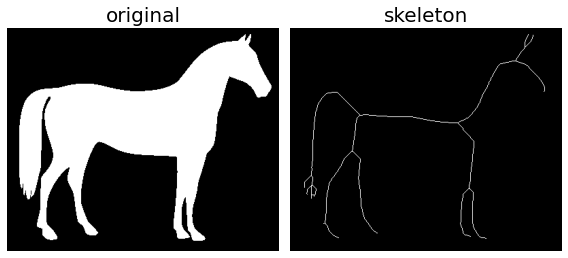

In [3]:
# Invert the horse image
image = invert(data.horse())

# perform skeletonization
skeleton = skeletonize(image)

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()


# Zhang's Algorithm

[Zha84] A fast parallel algorithm for thinning digital patterns,
T. Y. Zhang and C. Y. Suen, Communications of the ACM,
March 1984, Volume 27, Number 3.

A binary image is defined by a matrix `M` where each pixel `M[i][j]` is either 0 or 1. A region in the image is more than 1 pixel thick.
Zhang's algorithm iterates over the image until stability applying a transformation on each pixel based on the values of neighbouring pixels.

Given an element of the matrix `M[i][j]` that we call $P_1$ the neighbours of $P_1$ are defined as follows.

|                    |                  |                    |
| ------------------ | ---------------- | ------------------ |
| $P_9$ `[i-1][j-1]` | $P_2$ `[i-1][j]` | $P_3$ `[i-1][j+1]` |
| $P_8$ `[i][j-1]`   | $P_1$ `[i][j]`   | $P_4$ `[i][j+1]`   |
| $P_7$ `[i+1][j-1]` | $P_6$ `[i+1][j]` | $P_5$ `[i+1][j+1]` |

Since it is a parallel algorithm the new value given to a pixel at the $n$-th iteration depends on ts own value as well as those of its eight neighbors at the $(n-1)$-th iteration. This allows all pixel to be processed simultanously.

For the sake of simplicity, my implementation processes pixels in series and do not utilize parallel programming tecniques.

The algorithm consist of iteratively removing all contour points which satify some conditions. An iteration is divided into two sub-iterations with different conditions to be satisfied.

For sub-iteration 1 a point $P_1$ is deleted if the following conditions are satisfied:

1. $2 ≤ B(P_1) ≤ 6$
2. $A(P_1) = 1$
3. $P_2 * P_4 * P_6 = 0$
4. $P_4 * P_6 * P_8 = 0$

where $B(P_1)$ is the number of non zero neighbours of $P_1$ and $A(P_1)$ is the number of 0-1 patterns in the set of neighbours orderd as $P_2, P_3, \dots, P_8, P_9$.
Condition 1. and 2. are needed, respectively, in order to preserve the endpoints of a skeleton and to preserve connectivity, i.e. to prevent the deletion of points which lie between endpoints, as showed by the figure below.
Conditions 3. and 4. together allow to remove from the region an East or South boundary point or a North-West corner point.

![connectivity-endpoints.png](https://drive.google.com/uc?id=1a9l0QBQLm6NglUp4BGT04GurRVw6JFY8)

For sub-iteration 2 only condition 3. and 4. are changed as follows:

3. $P_2 * P_4 * P_8 = 0$
4. $P_2 * P_6 * P_8 = 0$

The new conditions 3. and 4. together allow to remove from the region an West or North boundary point or a South-East corner point.


In [109]:
def zhang_skeletonize(image, save_steps=False, path_to_save_steps="zhang/"):
    '''Given a 2D binary image, skeletonize it using Zhang's Method'''

    # add padding of zeros to avoid to access out of bounds
    cleaned_skeleton = np.pad(
        image, pad_width=1, mode='constant', constant_values=0)
    rows, cols = cleaned_skeleton.shape
    skeleton = np.zeros((rows, cols), dtype=np.uint8)
    skeleton[:, :] = cleaned_skeleton > 0
    pixel_removed = True
    step = 0
    while pixel_removed:
        pixel_removed = False
        # Sub-iterations
        for sub_iter in range(1, 3):
            # Iteration over the image
            for i in range(1, rows-1):
                for j in range(1, cols-1):
                    if (skeleton[i, j] == 1):  # avoid already zero pixels
                        neighbours = get_neighbours(i, j, skeleton)
                        P2, P3, P4, P5, P6, P7, P8, P9 = neighbours
                        non_zero_neighbours = sum(neighbours)
                        if (2 <= non_zero_neighbours <= 6  # Condition 1.
                                and numberOfZeroOnePatterns(neighbours) == 1):  # Condition 2.
                            if (sub_iter == 1
                                    and P2*P4*P6 == 0 and P4*P6*P8 == 0):  # Condition 3. 4. sub-iteration 1
                                cleaned_skeleton[i, j] = 0
                                pixel_removed = True
                            elif (sub_iter == 2
                                  and P2*P4*P8 == 0 and P2*P6*P8 == 0):  # Condition 3. 4. sub-iteration 2
                                cleaned_skeleton[i, j] = 0
                                pixel_removed = True

            skeleton[:, :] = cleaned_skeleton[:, :]
        if save_steps:
            write_frames(path_to_save_steps, skeleton, step)
        step += 1
    return skeleton[1:-1, 1:-1]


def get_neighbours(i, j, img):
    '''Return 8-neighbours of image point P1(x,y), in a clockwise order'''
    return [img[i-1, j], img[i-1, j+1], img[i, j+1], img[i+1, j+1],
            img[i+1, j], img[i+1, j-1], img[i, j-1], img[i-1, j-1]]


def numberOfZeroOnePatterns(neighbours):
    '''No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence'''
    n = neighbours + neighbours[0:1]  # P2, P3, ... , P8, P9, P2
    # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)
    return sum((a, b) == (0, 1) for a, b in zip(n, n[1:]))


def write_frames(path, image, index):
    image_to_print = image.astype(np.uint8)  # convert to an unsigned byte
    image_to_print *= 255
    cv2.imwrite(f"{path}img_{index:03}.png", image_to_print)


(328, 400)


Text(0.5, 0.98, "Zhang's method")

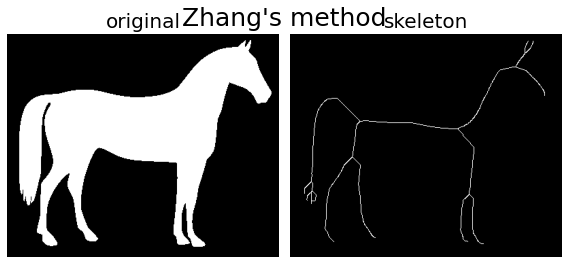

In [110]:
# Load image from skimage dataset
# Invert the horse image
image = np.array(invert(data.horse()))
print(image.shape)

# Skeletonize the image using Zhang's Method
skeleton = zhang_skeletonize(image)

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
fig.suptitle("Zhang's method", fontsize=25)


In [ ]:
# Create video from images
!ffmpeg - y - framerate 25 - pattern_type glob - i 'zhang/*.png' - c: v libx264 - pix_fmt yuv420p zhang/out.mp4


# Morphological Thinning

Morphological thinning is a morphological operation that removes pixels from a region of a binary image. As I said before it is commonly used as a skeletonization technique.

To do its magic morphological thinning relies on the Hit-and-Miss transform which one of the basic morphological operations.

### Hit-and-Miss Transform

The hit-and-miss transform is a general binary morphological operation that can be used to look for specific patterns of _foreground_ and _background_ pixels (respectively 1s and 0s pixels) an image.

It takes a binary image and a _structuring element_ or _kernel_ as input and outputs another binary image. The kernel can contain both 1s and 0s and some special `null` pixels which are not considered in the computation. For example in the following figure it is represented a 3x3 hit-and-miss kernel.

![isolate-point-kernel](https://drive.google.com/uc?id=1aHXhQh_BJ9ngTow08PK8RXTTKt6mVow6)

The hit-and-miss operation is performed simply iterating over all pixels of the image and comparing the _kernel_ with the underlying image pixels. If they exactly match the pixel under the pixel is set to 1 otherwise is set to 0.

### Thinning using the Hit-and-Miss Transform

The thinning operation is fairly simple. Given an image $I$ and a kernel $J$ is:

$ thin(I, J) = I-hit$-$and$-$miss(I,J)$

where the subtraction is the logical subtraction $X-Y = X \cap \neg Y$

In english, the pixel we're iterating on is set to 0 if the kernel and the underlying image pixels ("the neighborhood") _do not_ exactly match otherwise, it is left unchanged.

In order to obtain a skeleton the complete pass over the pixels of the image should be repeated until it causes no further changes.

### Skeletonization kernels

Skeletonization should erode away the boundaries of the object region as much as possible preserving the topological characteristics of the object, i.e. connectivity, holes, geometry etc.

This can be achieved using the two kernels shown below and all their 90° rotations. The first allows to detect a pixel belonging to a Nord, South, East or West border which can be deleted. The second allows to detect a pixel belonging to a Nord-East, South-East, Nord-West or South-West corner which can be deleted.

This can be achieved using the two kernels shown below and all their 90° rotations. In this way we're determining the _octagonal skeleton_ of the region, i.e. the set of point that lie at the centers of octagons that fit entirely inside the region without touching the boundary at at least two points.
This method is guaranteed to produce a connected skeleton.

![corner-kernel](https://drive.google.com/uc?id=1aKpZhFD11uUJcW4i3bKvWYazgB13oFkN)
![border-kernel](https://drive.google.com/uc?id=1aG2FNu6ID3N8PoGkXGMYYzIuc9jxpQYI)

Skeletons obtained by this tecnique can present short spurs produced by small irregularities in the boundary of the original object. In the image below it is possibile to see the spurs after obtaining the skeleton.

![spur-example](https://drive.google.com/uc?id=1aRpBKrHLvxQXYr2kcSe4BZqZlALjSKBU)

These spurs can be removed by a process called pruning. The kernels used to perform pruning are the following and all their 90° rotations. Pruning should be performed for a fixed number of iterations instead of to convergence since pruning until convergence will actually remove all pixels except those that form closed loops.

![spur-1-kernel](https://drive.google.com/uc?id=1aPYgHMVB4Li7wBXwUA4c761oG2BHoaf9)
![spur-2-kernel](https://drive.google.com/uc?id=1aR4UJLXKcqgU0ojC6LYUvbGnc5nw-pDI)


In [138]:
# 0 pixels are the "null" pixels, -1 pixels are background pixels, 1 pixels are foreground pixels
border_kernel = np.array([[0, -1, -1], [1, 1, -1], [0, 1, 0]], dtype="int")
corner_kernel = np.array([[-1, -1, -1], [0, 1, 0], [1, 1, 1]], dtype="int")

kernels = [
    border_kernel,
    corner_kernel,
    np.rot90(border_kernel),
    np.rot90(corner_kernel),
    np.rot90(np.rot90(border_kernel)),
    np.rot90(np.rot90(corner_kernel)),
    np.rot90(np.rot90(np.rot90(border_kernel))),
    np.rot90(np.rot90(np.rot90(corner_kernel)))
]

spur1_kernel = np.array([[-1, -1, -1], [-1, 1, -1], [0, 0, -1]], dtype="int")
spur2_kernel = np.array([[-1, -1, -1], [-1, 1, -1], [-1, 0, 0]], dtype="int")

spur_kernels = [
    spur1_kernel,
    spur2_kernel,
    np.rot90(spur1_kernel),
    np.rot90(spur2_kernel),
    np.rot90(np.rot90(spur1_kernel)),
    np.rot90(np.rot90(spur2_kernel)),
    np.rot90(np.rot90(np.rot90(spur1_kernel))),
    np.rot90(np.rot90(np.rot90(spur2_kernel))),
]


def write_frames(path, image, index, show=False):
    image_to_print = image.astype(np.uint8)  # convert to an unsigned byte
    image_to_print *= 255
    cv2.imwrite(f"{path}img_{index:03}.png", image_to_print)
    if show:
        cv2.imshow("Frame", image_to_print)
        cv2.waitKey(0)


def morph_thinning_skeletonize(image, save_steps=False, path_to_save_steps="morph_thinning/", pruning=False, pruning_iters=10):
    '''Given a 2D binary image, skeletonize it using Zhang's Method'''

    # add padding of zeros to avoid to access out of bounds
    cleaned_skeleton = np.pad(
        image, pad_width=1, mode='constant', constant_values=0)
    cleaned_skeleton = cleaned_skeleton.astype(np.uint8)
    rows, cols = cleaned_skeleton.shape
    skeleton = np.zeros(cleaned_skeleton.shape, dtype=np.uint8)
    skeleton[:, :] = cleaned_skeleton > 0
    pixel_removed = True
    step = 0
    while pixel_removed:
        pixel_removed = False

        for kernel in kernels:
            out_image = cv2.morphologyEx(
                cleaned_skeleton, cv2.MORPH_HITMISS, kernel)
            cleaned_skeleton = cleaned_skeleton - out_image

        if (not np.array_equal(skeleton, cleaned_skeleton)):
            pixel_removed = True
            skeleton = cleaned_skeleton

        if save_steps:
            if step % 1 == 0:
                write_frames(path_to_save_steps, skeleton, step)
        step += 1
        #print(f"Step {step}")

    if pruning:
        pixel_removed = True
        for i in range(pruning_iters):
            if not pixel_removed:
                break
            for kernel in spur_kernels:
                out_image = cv2.morphologyEx(
                    cleaned_skeleton, cv2.MORPH_HITMISS, kernel)
                cleaned_skeleton = cleaned_skeleton - out_image
            if (not np.array_equal(skeleton, cleaned_skeleton)):
                skeleton = cleaned_skeleton
                pixel_removed = True
            if save_steps:
                write_frames(path_to_save_steps, skeleton, step+i)
                #print(f"Pruning step {i}")

    return skeleton[1:-1, 1:-1]


(328, 400)


Text(0.5, 0.98, 'Morphological Thinning')

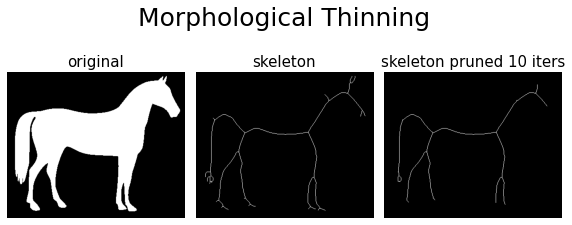

In [139]:
# Load image from skimage dataset
# Invert the horse image
image = np.array(invert(data.horse()))
print(image.shape)

skeleton_pruned = morph_thinning_skeletonize(
    image, save_steps=True, path_to_save_steps="morph_thinning/", pruning=True)
skeleton = morph_thinning_skeletonize(
    image, save_steps=True, path_to_save_steps="morph_thinning/")

# display results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=15)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=15)

ax[2].imshow(skeleton_pruned, cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('skeleton pruned 10 iters', fontsize=15)

fig.tight_layout()
fig.suptitle("Morphological Thinning", fontsize=25)


In [ ]:
!ffmpeg - y - framerate 25 - pattern_type glob - i 'morph_thinning/*.png' - c: v libx264 - pix_fmt yuv420p morph_thinning/out.mp4
